In [16]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import numpy as np
import warnings
from pandas.api.types import CategoricalDtype

warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

In [62]:
def cal_plot(x):
    if 1<= x <= 10:
        return 6
    elif 11 <= x <= 20:
        return 5
    elif 21 <= x <= 30:
        return 4
    elif 31 <= x <= 40:
        return 3
    
    elif 41 <= x <= 50:
        return 7
    elif 51 <= x <= 60:
        return 8
    elif 61 <= x <= 70:
        return 2
    elif 71 <= x <= 80:
        return 1

In [77]:
df = pd.read_csv("../output/2324_growth.csv")
df['plot'] = df['ID'].apply(cal_plot)


# df['plot'] = ((df['ID'] - 1) // 10) + 1

df['year'] = '20' + (df['date'].astype(str).str[0:2])
df['year'] = df['year'].astype(int)
df['초장(cm)'] = df.apply(lambda row: row['간장(cm)'] + row['수장(cm)'] if pd.isna(row['초장(cm)']) else row['초장(cm)'], axis=1)
df['생육단계_숫자'] = pd.Categorical(df['생육단계'], categories=['분얼전기', '분얼후기', '개화기', '개화후2주', '개화후4주', '수확기'],
                               ordered=True).codes
df['파종'] = df['plot'].apply(lambda x: '광산' if x <= 4 else '세조')
df['시비'] = df['plot'].apply(lambda x: '추비' if x in [2, 3, 6, 7] else '기비')
df['파종_시비'] = df['파종'] + '_' + df['시비']
df

,ID,생육단계,LAI,SPAD,유수길이(mm),초장(cm),1수영화수,간장(cm),경수(20*20cm2),수장(cm),...,NDRE,GNDVI,RVI,CVI,plot,year,생육단계_숫자,파종,시비,파종_시비
0,1,분얼전기,0.07,37.6,1.5,20.0,NaN,NaN,NaN,NaN,...,0.168714,0.495609,2.557755,0.378150,6,2023,0,세조,추비,세조_추비
1,2,분얼전기,0.07,38.1,1.2,22.0,NaN,NaN,NaN,NaN,...,0.086592,0.359478,1.438161,0.391021,6,2023,0,세조,추비,세조_추비
2,3,분얼전기,0.07,38.7,1.5,18.0,NaN,NaN,NaN,NaN,...,0.086231,0.356621,1.450934,0.395626,6,2023,0,세조,추비,세조_추비
3,4,분얼전기,0.08,39.2,1.0,18.5,NaN,NaN,NaN,NaN,...,0.107743,0.399532,1.631073,0.388953,6,2023,0,세조,추비,세조_추비
4,5,분얼전기,0.08,39.7,0.7,19.5,NaN,NaN,NaN,NaN,...,0.100531,0.390062,1.647158,0.441491,6,2023,0,세조,추비,세조_추비
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
955,76,수확기,1.12,10.2,NaN,67.0,NaN,59.0,48.0,8.0,...,0.112781,0.478998,1.476466,0.055060,1,2024,5,광산,기비,광산_기비
956,77,수확기,1.04,10.5,NaN,63.5,NaN,56.0,NaN,7.5,...,0.143057,0.500372,1.567627,0.058452,1,2024,5,광산,기비,광산_기비
957,78,수확기,1.07,9.4,NaN,63.5,NaN,56.0,NaN,7.5,...,0.121646,0.488268,1.501483,0.056885,1,2024,5,광산,기비,광산_기비
958,79,수확기,0.93,11.9,NaN,68.0,NaN,60.0,NaN,8.0,...,0.124400,0.489779,1.551465,0.055377,1,2024,5,광산,기비,광산_기비


In [64]:
def data_mean(target):
    y_variables = ['초장(cm)', 'LAI', 'SPAD', 'NDVI', 'GNDVI', 'RVI', 'CVI', 'NDRE']

    df_mean = df.groupby(['year', '생육단계', target])[y_variables].mean().reset_index()

    growth_stages = ['분얼전기', '분얼후기', '개화기', '개화후2주', '개화후4주', '수확기']
    df_mean['생육단계'] = pd.Categorical(df_mean['생육단계'], categories=growth_stages, ordered=True)

    # 데이터 정렬
    df_mean = df_mean.sort_values('생육단계')

    return df_mean

In [74]:
def data_draw(target, df_mean, y, con):
    if con == '생육':
        colors = {}
        if target == '시비':
            colors = {'기비': 'green', '추비': 'orange'}
        elif target == '파종':
            colors = {'광산': 'blue', '세조': 'red'}
        elif target == '파종_시비':
            colors = {'광산_기비': 'blue', '광산_추비': 'red', '세조_기비': 'green', '세조_추비': 'orange'}
    else:    
        colors = {}
        if target == '시비':
            # colors = {'기비': 'lightskyblue', '추비': 'lightcoral'}
            colors = {'기비': 'lightgreen', '추비': 'lightsalmon'}
        elif target == '파종':
            colors = {'광산': 'lightskyblue', '세조': 'lightcoral'}
        elif target == '파종_시비':
            colors = {
                '광산_기비': 'lightskyblue',
                '광산_추비': 'lightcoral',
                '세조_기비': 'lightgreen',
                '세조_추비': 'lightsalmon'
            }
    linestyles = {2023: '--', 2024: '-'}

    # 그래프 그리기
    fig, ax = plt.subplots(figsize=(5, 3))

    for (year, target), group in df_mean.groupby(['year', target]):
        display(df_mean)

        # group['생육단계'] = group['생육단계'].astype(CategoricalDtype(categories=['분얼전기', '분얼후기', '개화기', '개화후2주', '개화후4주', '수확기'], ordered=True))

        ax.plot(
            group['생육단계'],
            group[y],  # 'LAI'로 변경하려면 여기를 수정하세요.
            label=f'{year} - {target}',
            color=colors[target],
            linestyle=linestyles[year],
            marker='o'  # 각 지점을 강조하려면 추가
        )

    ax.set_xlabel('생육단계')
    ax.set_ylabel(y)
    ax.set_title(f'생육단계별 {y}')
    # ax.legend()
    plt.show()

    # fig, axes = plt.subplots(3, 3, figsize=(15, 15))
    # fig.subplots_adjust(hspace=0.5, wspace=0.3)
    # 
    # y_values = ['초장(cm)', 'LAI', 'SPAD', 'NDVI', 'GNDVI', 'RVI', 'CVI', 'NDRE']
    # 
    # for i, ax in enumerate(axes.flat):
    #     if i < len(y_values):
    #         y_col = y_values[i]
    #         for (year, target), group in df_mean.groupby(['year', target]):
    #             ax.plot(
    #                 group['생육단계'],
    #                 group[y_col],
    #                 label=f'{year} - {target}',
    #                 color=colors[target],
    #                 linestyle=linestyles[year],
    #                 marker='o'
    #             )
    #         ax.set_title(f'{y_col} 그래프')
    #         ax.set_xlabel('생육단계')
    #         ax.set_ylabel(y_col)
    #         ax.legend()
    #     else:
    #         ax.axis('off')
    # 
    # plt.show()

In [75]:
df_mean

,year,생육단계,시비,초장(cm),LAI,SPAD,NDVI,GNDVI,RVI,CVI,NDRE
19,2024,분얼전기,추비,18.0250,0.51350,35.7675,0.532022,0.500342,4.841085,0.026715,0.229112
18,2024,분얼전기,기비,20.7250,0.57425,34.8525,0.540145,0.504792,5.084960,0.026709,0.234012
7,2023,분얼전기,추비,19.8950,0.14800,37.0625,0.217667,0.394159,1.597134,0.445583,0.099015
6,2023,분얼전기,기비,20.1750,0.09950,40.5125,0.216898,0.392929,1.592585,0.455018,0.099176
20,2024,분얼후기,기비,54.6250,1.63500,43.7525,0.825273,0.692840,13.077876,0.028421,0.401036
21,2024,분얼후기,추비,53.1500,1.11550,40.7675,0.841337,0.725820,14.685837,0.033823,0.451934
8,2023,분얼후기,기비,41.8000,1.01775,46.8475,0.566536,0.603128,4.503692,0.094855,0.260063
9,2023,분얼후기,추비,40.1875,1.10400,44.3725,0.547776,0.592377,4.615248,0.095393,0.247428
1,2023,개화기,추비,61.6000,1.00225,49.4150,0.654768,0.695043,7.842630,0.158890,0.325070
12,2024,개화기,기비,83.0000,2.90450,45.8675,0.811788,0.739498,12.307129,0.045507,0.409072


,year,생육단계,시비,초장(cm),LAI,SPAD,NDVI,GNDVI,RVI,CVI,NDRE
19,2024,분얼전기,추비,18.0250,0.51350,35.7675,0.532022,0.500342,4.841085,0.026715,0.229112
18,2024,분얼전기,기비,20.7250,0.57425,34.8525,0.540145,0.504792,5.084960,0.026709,0.234012
7,2023,분얼전기,추비,19.8950,0.14800,37.0625,0.217667,0.394159,1.597134,0.445583,0.099015
6,2023,분얼전기,기비,20.1750,0.09950,40.5125,0.216898,0.392929,1.592585,0.455018,0.099176
20,2024,분얼후기,기비,54.6250,1.63500,43.7525,0.825273,0.692840,13.077876,0.028421,0.401036
21,2024,분얼후기,추비,53.1500,1.11550,40.7675,0.841337,0.725820,14.685837,0.033823,0.451934
8,2023,분얼후기,기비,41.8000,1.01775,46.8475,0.566536,0.603128,4.503692,0.094855,0.260063
9,2023,분얼후기,추비,40.1875,1.10400,44.3725,0.547776,0.592377,4.615248,0.095393,0.247428
1,2023,개화기,추비,61.6000,1.00225,49.4150,0.654768,0.695043,7.842630,0.158890,0.325070
12,2024,개화기,기비,83.0000,2.90450,45.8675,0.811788,0.739498,12.307129,0.045507,0.409072


,year,생육단계,시비,초장(cm),LAI,SPAD,NDVI,GNDVI,RVI,CVI,NDRE
19,2024,분얼전기,추비,18.0250,0.51350,35.7675,0.532022,0.500342,4.841085,0.026715,0.229112
18,2024,분얼전기,기비,20.7250,0.57425,34.8525,0.540145,0.504792,5.084960,0.026709,0.234012
7,2023,분얼전기,추비,19.8950,0.14800,37.0625,0.217667,0.394159,1.597134,0.445583,0.099015
6,2023,분얼전기,기비,20.1750,0.09950,40.5125,0.216898,0.392929,1.592585,0.455018,0.099176
20,2024,분얼후기,기비,54.6250,1.63500,43.7525,0.825273,0.692840,13.077876,0.028421,0.401036
21,2024,분얼후기,추비,53.1500,1.11550,40.7675,0.841337,0.725820,14.685837,0.033823,0.451934
8,2023,분얼후기,기비,41.8000,1.01775,46.8475,0.566536,0.603128,4.503692,0.094855,0.260063
9,2023,분얼후기,추비,40.1875,1.10400,44.3725,0.547776,0.592377,4.615248,0.095393,0.247428
1,2023,개화기,추비,61.6000,1.00225,49.4150,0.654768,0.695043,7.842630,0.158890,0.325070
12,2024,개화기,기비,83.0000,2.90450,45.8675,0.811788,0.739498,12.307129,0.045507,0.409072


,year,생육단계,시비,초장(cm),LAI,SPAD,NDVI,GNDVI,RVI,CVI,NDRE
19,2024,분얼전기,추비,18.0250,0.51350,35.7675,0.532022,0.500342,4.841085,0.026715,0.229112
18,2024,분얼전기,기비,20.7250,0.57425,34.8525,0.540145,0.504792,5.084960,0.026709,0.234012
7,2023,분얼전기,추비,19.8950,0.14800,37.0625,0.217667,0.394159,1.597134,0.445583,0.099015
6,2023,분얼전기,기비,20.1750,0.09950,40.5125,0.216898,0.392929,1.592585,0.455018,0.099176
20,2024,분얼후기,기비,54.6250,1.63500,43.7525,0.825273,0.692840,13.077876,0.028421,0.401036
21,2024,분얼후기,추비,53.1500,1.11550,40.7675,0.841337,0.725820,14.685837,0.033823,0.451934
8,2023,분얼후기,기비,41.8000,1.01775,46.8475,0.566536,0.603128,4.503692,0.094855,0.260063
9,2023,분얼후기,추비,40.1875,1.10400,44.3725,0.547776,0.592377,4.615248,0.095393,0.247428
1,2023,개화기,추비,61.6000,1.00225,49.4150,0.654768,0.695043,7.842630,0.158890,0.325070
12,2024,개화기,기비,83.0000,2.90450,45.8675,0.811788,0.739498,12.307129,0.045507,0.409072


,year,생육단계,시비,초장(cm),LAI,SPAD,NDVI,GNDVI,RVI,CVI,NDRE
19,2024,분얼전기,추비,18.0250,0.51350,35.7675,0.532022,0.500342,4.841085,0.026715,0.229112
18,2024,분얼전기,기비,20.7250,0.57425,34.8525,0.540145,0.504792,5.084960,0.026709,0.234012
7,2023,분얼전기,추비,19.8950,0.14800,37.0625,0.217667,0.394159,1.597134,0.445583,0.099015
6,2023,분얼전기,기비,20.1750,0.09950,40.5125,0.216898,0.392929,1.592585,0.455018,0.099176
20,2024,분얼후기,기비,54.6250,1.63500,43.7525,0.825273,0.692840,13.077876,0.028421,0.401036
21,2024,분얼후기,추비,53.1500,1.11550,40.7675,0.841337,0.725820,14.685837,0.033823,0.451934
8,2023,분얼후기,기비,41.8000,1.01775,46.8475,0.566536,0.603128,4.503692,0.094855,0.260063
9,2023,분얼후기,추비,40.1875,1.10400,44.3725,0.547776,0.592377,4.615248,0.095393,0.247428
1,2023,개화기,추비,61.6000,1.00225,49.4150,0.654768,0.695043,7.842630,0.158890,0.325070
12,2024,개화기,기비,83.0000,2.90450,45.8675,0.811788,0.739498,12.307129,0.045507,0.409072


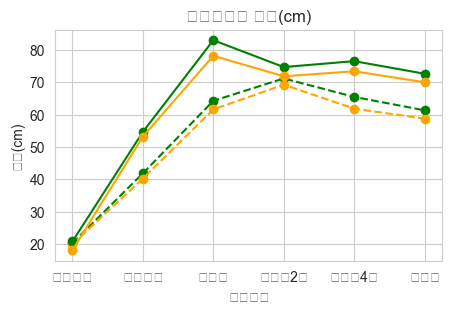

,year,생육단계,시비,초장(cm),LAI,SPAD,NDVI,GNDVI,RVI,CVI,NDRE
19,2024,분얼전기,추비,18.0250,0.51350,35.7675,0.532022,0.500342,4.841085,0.026715,0.229112
18,2024,분얼전기,기비,20.7250,0.57425,34.8525,0.540145,0.504792,5.084960,0.026709,0.234012
7,2023,분얼전기,추비,19.8950,0.14800,37.0625,0.217667,0.394159,1.597134,0.445583,0.099015
6,2023,분얼전기,기비,20.1750,0.09950,40.5125,0.216898,0.392929,1.592585,0.455018,0.099176
20,2024,분얼후기,기비,54.6250,1.63500,43.7525,0.825273,0.692840,13.077876,0.028421,0.401036
21,2024,분얼후기,추비,53.1500,1.11550,40.7675,0.841337,0.725820,14.685837,0.033823,0.451934
8,2023,분얼후기,기비,41.8000,1.01775,46.8475,0.566536,0.603128,4.503692,0.094855,0.260063
9,2023,분얼후기,추비,40.1875,1.10400,44.3725,0.547776,0.592377,4.615248,0.095393,0.247428
1,2023,개화기,추비,61.6000,1.00225,49.4150,0.654768,0.695043,7.842630,0.158890,0.325070
12,2024,개화기,기비,83.0000,2.90450,45.8675,0.811788,0.739498,12.307129,0.045507,0.409072


,year,생육단계,시비,초장(cm),LAI,SPAD,NDVI,GNDVI,RVI,CVI,NDRE
19,2024,분얼전기,추비,18.0250,0.51350,35.7675,0.532022,0.500342,4.841085,0.026715,0.229112
18,2024,분얼전기,기비,20.7250,0.57425,34.8525,0.540145,0.504792,5.084960,0.026709,0.234012
7,2023,분얼전기,추비,19.8950,0.14800,37.0625,0.217667,0.394159,1.597134,0.445583,0.099015
6,2023,분얼전기,기비,20.1750,0.09950,40.5125,0.216898,0.392929,1.592585,0.455018,0.099176
20,2024,분얼후기,기비,54.6250,1.63500,43.7525,0.825273,0.692840,13.077876,0.028421,0.401036
21,2024,분얼후기,추비,53.1500,1.11550,40.7675,0.841337,0.725820,14.685837,0.033823,0.451934
8,2023,분얼후기,기비,41.8000,1.01775,46.8475,0.566536,0.603128,4.503692,0.094855,0.260063
9,2023,분얼후기,추비,40.1875,1.10400,44.3725,0.547776,0.592377,4.615248,0.095393,0.247428
1,2023,개화기,추비,61.6000,1.00225,49.4150,0.654768,0.695043,7.842630,0.158890,0.325070
12,2024,개화기,기비,83.0000,2.90450,45.8675,0.811788,0.739498,12.307129,0.045507,0.409072


,year,생육단계,시비,초장(cm),LAI,SPAD,NDVI,GNDVI,RVI,CVI,NDRE
19,2024,분얼전기,추비,18.0250,0.51350,35.7675,0.532022,0.500342,4.841085,0.026715,0.229112
18,2024,분얼전기,기비,20.7250,0.57425,34.8525,0.540145,0.504792,5.084960,0.026709,0.234012
7,2023,분얼전기,추비,19.8950,0.14800,37.0625,0.217667,0.394159,1.597134,0.445583,0.099015
6,2023,분얼전기,기비,20.1750,0.09950,40.5125,0.216898,0.392929,1.592585,0.455018,0.099176
20,2024,분얼후기,기비,54.6250,1.63500,43.7525,0.825273,0.692840,13.077876,0.028421,0.401036
21,2024,분얼후기,추비,53.1500,1.11550,40.7675,0.841337,0.725820,14.685837,0.033823,0.451934
8,2023,분얼후기,기비,41.8000,1.01775,46.8475,0.566536,0.603128,4.503692,0.094855,0.260063
9,2023,분얼후기,추비,40.1875,1.10400,44.3725,0.547776,0.592377,4.615248,0.095393,0.247428
1,2023,개화기,추비,61.6000,1.00225,49.4150,0.654768,0.695043,7.842630,0.158890,0.325070
12,2024,개화기,기비,83.0000,2.90450,45.8675,0.811788,0.739498,12.307129,0.045507,0.409072


,year,생육단계,시비,초장(cm),LAI,SPAD,NDVI,GNDVI,RVI,CVI,NDRE
19,2024,분얼전기,추비,18.0250,0.51350,35.7675,0.532022,0.500342,4.841085,0.026715,0.229112
18,2024,분얼전기,기비,20.7250,0.57425,34.8525,0.540145,0.504792,5.084960,0.026709,0.234012
7,2023,분얼전기,추비,19.8950,0.14800,37.0625,0.217667,0.394159,1.597134,0.445583,0.099015
6,2023,분얼전기,기비,20.1750,0.09950,40.5125,0.216898,0.392929,1.592585,0.455018,0.099176
20,2024,분얼후기,기비,54.6250,1.63500,43.7525,0.825273,0.692840,13.077876,0.028421,0.401036
21,2024,분얼후기,추비,53.1500,1.11550,40.7675,0.841337,0.725820,14.685837,0.033823,0.451934
8,2023,분얼후기,기비,41.8000,1.01775,46.8475,0.566536,0.603128,4.503692,0.094855,0.260063
9,2023,분얼후기,추비,40.1875,1.10400,44.3725,0.547776,0.592377,4.615248,0.095393,0.247428
1,2023,개화기,추비,61.6000,1.00225,49.4150,0.654768,0.695043,7.842630,0.158890,0.325070
12,2024,개화기,기비,83.0000,2.90450,45.8675,0.811788,0.739498,12.307129,0.045507,0.409072


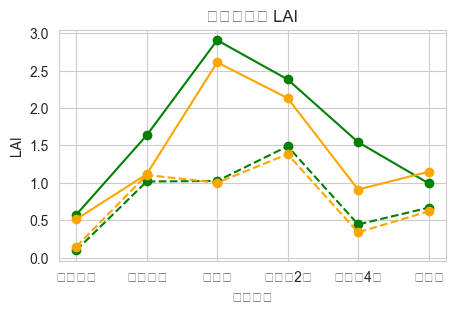

,year,생육단계,시비,초장(cm),LAI,SPAD,NDVI,GNDVI,RVI,CVI,NDRE
19,2024,분얼전기,추비,18.0250,0.51350,35.7675,0.532022,0.500342,4.841085,0.026715,0.229112
18,2024,분얼전기,기비,20.7250,0.57425,34.8525,0.540145,0.504792,5.084960,0.026709,0.234012
7,2023,분얼전기,추비,19.8950,0.14800,37.0625,0.217667,0.394159,1.597134,0.445583,0.099015
6,2023,분얼전기,기비,20.1750,0.09950,40.5125,0.216898,0.392929,1.592585,0.455018,0.099176
20,2024,분얼후기,기비,54.6250,1.63500,43.7525,0.825273,0.692840,13.077876,0.028421,0.401036
21,2024,분얼후기,추비,53.1500,1.11550,40.7675,0.841337,0.725820,14.685837,0.033823,0.451934
8,2023,분얼후기,기비,41.8000,1.01775,46.8475,0.566536,0.603128,4.503692,0.094855,0.260063
9,2023,분얼후기,추비,40.1875,1.10400,44.3725,0.547776,0.592377,4.615248,0.095393,0.247428
1,2023,개화기,추비,61.6000,1.00225,49.4150,0.654768,0.695043,7.842630,0.158890,0.325070
12,2024,개화기,기비,83.0000,2.90450,45.8675,0.811788,0.739498,12.307129,0.045507,0.409072


,year,생육단계,시비,초장(cm),LAI,SPAD,NDVI,GNDVI,RVI,CVI,NDRE
19,2024,분얼전기,추비,18.0250,0.51350,35.7675,0.532022,0.500342,4.841085,0.026715,0.229112
18,2024,분얼전기,기비,20.7250,0.57425,34.8525,0.540145,0.504792,5.084960,0.026709,0.234012
7,2023,분얼전기,추비,19.8950,0.14800,37.0625,0.217667,0.394159,1.597134,0.445583,0.099015
6,2023,분얼전기,기비,20.1750,0.09950,40.5125,0.216898,0.392929,1.592585,0.455018,0.099176
20,2024,분얼후기,기비,54.6250,1.63500,43.7525,0.825273,0.692840,13.077876,0.028421,0.401036
21,2024,분얼후기,추비,53.1500,1.11550,40.7675,0.841337,0.725820,14.685837,0.033823,0.451934
8,2023,분얼후기,기비,41.8000,1.01775,46.8475,0.566536,0.603128,4.503692,0.094855,0.260063
9,2023,분얼후기,추비,40.1875,1.10400,44.3725,0.547776,0.592377,4.615248,0.095393,0.247428
1,2023,개화기,추비,61.6000,1.00225,49.4150,0.654768,0.695043,7.842630,0.158890,0.325070
12,2024,개화기,기비,83.0000,2.90450,45.8675,0.811788,0.739498,12.307129,0.045507,0.409072


,year,생육단계,시비,초장(cm),LAI,SPAD,NDVI,GNDVI,RVI,CVI,NDRE
19,2024,분얼전기,추비,18.0250,0.51350,35.7675,0.532022,0.500342,4.841085,0.026715,0.229112
18,2024,분얼전기,기비,20.7250,0.57425,34.8525,0.540145,0.504792,5.084960,0.026709,0.234012
7,2023,분얼전기,추비,19.8950,0.14800,37.0625,0.217667,0.394159,1.597134,0.445583,0.099015
6,2023,분얼전기,기비,20.1750,0.09950,40.5125,0.216898,0.392929,1.592585,0.455018,0.099176
20,2024,분얼후기,기비,54.6250,1.63500,43.7525,0.825273,0.692840,13.077876,0.028421,0.401036
21,2024,분얼후기,추비,53.1500,1.11550,40.7675,0.841337,0.725820,14.685837,0.033823,0.451934
8,2023,분얼후기,기비,41.8000,1.01775,46.8475,0.566536,0.603128,4.503692,0.094855,0.260063
9,2023,분얼후기,추비,40.1875,1.10400,44.3725,0.547776,0.592377,4.615248,0.095393,0.247428
1,2023,개화기,추비,61.6000,1.00225,49.4150,0.654768,0.695043,7.842630,0.158890,0.325070
12,2024,개화기,기비,83.0000,2.90450,45.8675,0.811788,0.739498,12.307129,0.045507,0.409072


,year,생육단계,시비,초장(cm),LAI,SPAD,NDVI,GNDVI,RVI,CVI,NDRE
19,2024,분얼전기,추비,18.0250,0.51350,35.7675,0.532022,0.500342,4.841085,0.026715,0.229112
18,2024,분얼전기,기비,20.7250,0.57425,34.8525,0.540145,0.504792,5.084960,0.026709,0.234012
7,2023,분얼전기,추비,19.8950,0.14800,37.0625,0.217667,0.394159,1.597134,0.445583,0.099015
6,2023,분얼전기,기비,20.1750,0.09950,40.5125,0.216898,0.392929,1.592585,0.455018,0.099176
20,2024,분얼후기,기비,54.6250,1.63500,43.7525,0.825273,0.692840,13.077876,0.028421,0.401036
21,2024,분얼후기,추비,53.1500,1.11550,40.7675,0.841337,0.725820,14.685837,0.033823,0.451934
8,2023,분얼후기,기비,41.8000,1.01775,46.8475,0.566536,0.603128,4.503692,0.094855,0.260063
9,2023,분얼후기,추비,40.1875,1.10400,44.3725,0.547776,0.592377,4.615248,0.095393,0.247428
1,2023,개화기,추비,61.6000,1.00225,49.4150,0.654768,0.695043,7.842630,0.158890,0.325070
12,2024,개화기,기비,83.0000,2.90450,45.8675,0.811788,0.739498,12.307129,0.045507,0.409072


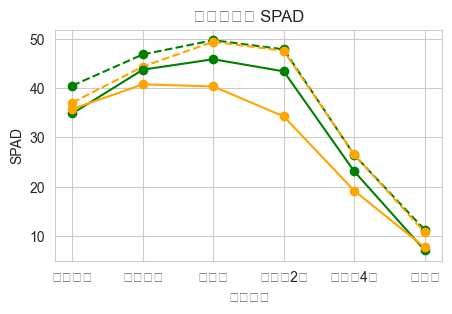

,year,생육단계,시비,초장(cm),LAI,SPAD,NDVI,GNDVI,RVI,CVI,NDRE
19,2024,분얼전기,추비,18.0250,0.51350,35.7675,0.532022,0.500342,4.841085,0.026715,0.229112
18,2024,분얼전기,기비,20.7250,0.57425,34.8525,0.540145,0.504792,5.084960,0.026709,0.234012
7,2023,분얼전기,추비,19.8950,0.14800,37.0625,0.217667,0.394159,1.597134,0.445583,0.099015
6,2023,분얼전기,기비,20.1750,0.09950,40.5125,0.216898,0.392929,1.592585,0.455018,0.099176
20,2024,분얼후기,기비,54.6250,1.63500,43.7525,0.825273,0.692840,13.077876,0.028421,0.401036
21,2024,분얼후기,추비,53.1500,1.11550,40.7675,0.841337,0.725820,14.685837,0.033823,0.451934
8,2023,분얼후기,기비,41.8000,1.01775,46.8475,0.566536,0.603128,4.503692,0.094855,0.260063
9,2023,분얼후기,추비,40.1875,1.10400,44.3725,0.547776,0.592377,4.615248,0.095393,0.247428
1,2023,개화기,추비,61.6000,1.00225,49.4150,0.654768,0.695043,7.842630,0.158890,0.325070
12,2024,개화기,기비,83.0000,2.90450,45.8675,0.811788,0.739498,12.307129,0.045507,0.409072


,year,생육단계,시비,초장(cm),LAI,SPAD,NDVI,GNDVI,RVI,CVI,NDRE
19,2024,분얼전기,추비,18.0250,0.51350,35.7675,0.532022,0.500342,4.841085,0.026715,0.229112
18,2024,분얼전기,기비,20.7250,0.57425,34.8525,0.540145,0.504792,5.084960,0.026709,0.234012
7,2023,분얼전기,추비,19.8950,0.14800,37.0625,0.217667,0.394159,1.597134,0.445583,0.099015
6,2023,분얼전기,기비,20.1750,0.09950,40.5125,0.216898,0.392929,1.592585,0.455018,0.099176
20,2024,분얼후기,기비,54.6250,1.63500,43.7525,0.825273,0.692840,13.077876,0.028421,0.401036
21,2024,분얼후기,추비,53.1500,1.11550,40.7675,0.841337,0.725820,14.685837,0.033823,0.451934
8,2023,분얼후기,기비,41.8000,1.01775,46.8475,0.566536,0.603128,4.503692,0.094855,0.260063
9,2023,분얼후기,추비,40.1875,1.10400,44.3725,0.547776,0.592377,4.615248,0.095393,0.247428
1,2023,개화기,추비,61.6000,1.00225,49.4150,0.654768,0.695043,7.842630,0.158890,0.325070
12,2024,개화기,기비,83.0000,2.90450,45.8675,0.811788,0.739498,12.307129,0.045507,0.409072


,year,생육단계,시비,초장(cm),LAI,SPAD,NDVI,GNDVI,RVI,CVI,NDRE
19,2024,분얼전기,추비,18.0250,0.51350,35.7675,0.532022,0.500342,4.841085,0.026715,0.229112
18,2024,분얼전기,기비,20.7250,0.57425,34.8525,0.540145,0.504792,5.084960,0.026709,0.234012
7,2023,분얼전기,추비,19.8950,0.14800,37.0625,0.217667,0.394159,1.597134,0.445583,0.099015
6,2023,분얼전기,기비,20.1750,0.09950,40.5125,0.216898,0.392929,1.592585,0.455018,0.099176
20,2024,분얼후기,기비,54.6250,1.63500,43.7525,0.825273,0.692840,13.077876,0.028421,0.401036
21,2024,분얼후기,추비,53.1500,1.11550,40.7675,0.841337,0.725820,14.685837,0.033823,0.451934
8,2023,분얼후기,기비,41.8000,1.01775,46.8475,0.566536,0.603128,4.503692,0.094855,0.260063
9,2023,분얼후기,추비,40.1875,1.10400,44.3725,0.547776,0.592377,4.615248,0.095393,0.247428
1,2023,개화기,추비,61.6000,1.00225,49.4150,0.654768,0.695043,7.842630,0.158890,0.325070
12,2024,개화기,기비,83.0000,2.90450,45.8675,0.811788,0.739498,12.307129,0.045507,0.409072


,year,생육단계,시비,초장(cm),LAI,SPAD,NDVI,GNDVI,RVI,CVI,NDRE
19,2024,분얼전기,추비,18.0250,0.51350,35.7675,0.532022,0.500342,4.841085,0.026715,0.229112
18,2024,분얼전기,기비,20.7250,0.57425,34.8525,0.540145,0.504792,5.084960,0.026709,0.234012
7,2023,분얼전기,추비,19.8950,0.14800,37.0625,0.217667,0.394159,1.597134,0.445583,0.099015
6,2023,분얼전기,기비,20.1750,0.09950,40.5125,0.216898,0.392929,1.592585,0.455018,0.099176
20,2024,분얼후기,기비,54.6250,1.63500,43.7525,0.825273,0.692840,13.077876,0.028421,0.401036
21,2024,분얼후기,추비,53.1500,1.11550,40.7675,0.841337,0.725820,14.685837,0.033823,0.451934
8,2023,분얼후기,기비,41.8000,1.01775,46.8475,0.566536,0.603128,4.503692,0.094855,0.260063
9,2023,분얼후기,추비,40.1875,1.10400,44.3725,0.547776,0.592377,4.615248,0.095393,0.247428
1,2023,개화기,추비,61.6000,1.00225,49.4150,0.654768,0.695043,7.842630,0.158890,0.325070
12,2024,개화기,기비,83.0000,2.90450,45.8675,0.811788,0.739498,12.307129,0.045507,0.409072


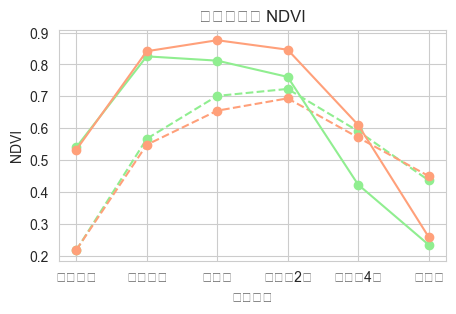

,year,생육단계,시비,초장(cm),LAI,SPAD,NDVI,GNDVI,RVI,CVI,NDRE
19,2024,분얼전기,추비,18.0250,0.51350,35.7675,0.532022,0.500342,4.841085,0.026715,0.229112
18,2024,분얼전기,기비,20.7250,0.57425,34.8525,0.540145,0.504792,5.084960,0.026709,0.234012
7,2023,분얼전기,추비,19.8950,0.14800,37.0625,0.217667,0.394159,1.597134,0.445583,0.099015
6,2023,분얼전기,기비,20.1750,0.09950,40.5125,0.216898,0.392929,1.592585,0.455018,0.099176
20,2024,분얼후기,기비,54.6250,1.63500,43.7525,0.825273,0.692840,13.077876,0.028421,0.401036
21,2024,분얼후기,추비,53.1500,1.11550,40.7675,0.841337,0.725820,14.685837,0.033823,0.451934
8,2023,분얼후기,기비,41.8000,1.01775,46.8475,0.566536,0.603128,4.503692,0.094855,0.260063
9,2023,분얼후기,추비,40.1875,1.10400,44.3725,0.547776,0.592377,4.615248,0.095393,0.247428
1,2023,개화기,추비,61.6000,1.00225,49.4150,0.654768,0.695043,7.842630,0.158890,0.325070
12,2024,개화기,기비,83.0000,2.90450,45.8675,0.811788,0.739498,12.307129,0.045507,0.409072


,year,생육단계,시비,초장(cm),LAI,SPAD,NDVI,GNDVI,RVI,CVI,NDRE
19,2024,분얼전기,추비,18.0250,0.51350,35.7675,0.532022,0.500342,4.841085,0.026715,0.229112
18,2024,분얼전기,기비,20.7250,0.57425,34.8525,0.540145,0.504792,5.084960,0.026709,0.234012
7,2023,분얼전기,추비,19.8950,0.14800,37.0625,0.217667,0.394159,1.597134,0.445583,0.099015
6,2023,분얼전기,기비,20.1750,0.09950,40.5125,0.216898,0.392929,1.592585,0.455018,0.099176
20,2024,분얼후기,기비,54.6250,1.63500,43.7525,0.825273,0.692840,13.077876,0.028421,0.401036
21,2024,분얼후기,추비,53.1500,1.11550,40.7675,0.841337,0.725820,14.685837,0.033823,0.451934
8,2023,분얼후기,기비,41.8000,1.01775,46.8475,0.566536,0.603128,4.503692,0.094855,0.260063
9,2023,분얼후기,추비,40.1875,1.10400,44.3725,0.547776,0.592377,4.615248,0.095393,0.247428
1,2023,개화기,추비,61.6000,1.00225,49.4150,0.654768,0.695043,7.842630,0.158890,0.325070
12,2024,개화기,기비,83.0000,2.90450,45.8675,0.811788,0.739498,12.307129,0.045507,0.409072


,year,생육단계,시비,초장(cm),LAI,SPAD,NDVI,GNDVI,RVI,CVI,NDRE
19,2024,분얼전기,추비,18.0250,0.51350,35.7675,0.532022,0.500342,4.841085,0.026715,0.229112
18,2024,분얼전기,기비,20.7250,0.57425,34.8525,0.540145,0.504792,5.084960,0.026709,0.234012
7,2023,분얼전기,추비,19.8950,0.14800,37.0625,0.217667,0.394159,1.597134,0.445583,0.099015
6,2023,분얼전기,기비,20.1750,0.09950,40.5125,0.216898,0.392929,1.592585,0.455018,0.099176
20,2024,분얼후기,기비,54.6250,1.63500,43.7525,0.825273,0.692840,13.077876,0.028421,0.401036
21,2024,분얼후기,추비,53.1500,1.11550,40.7675,0.841337,0.725820,14.685837,0.033823,0.451934
8,2023,분얼후기,기비,41.8000,1.01775,46.8475,0.566536,0.603128,4.503692,0.094855,0.260063
9,2023,분얼후기,추비,40.1875,1.10400,44.3725,0.547776,0.592377,4.615248,0.095393,0.247428
1,2023,개화기,추비,61.6000,1.00225,49.4150,0.654768,0.695043,7.842630,0.158890,0.325070
12,2024,개화기,기비,83.0000,2.90450,45.8675,0.811788,0.739498,12.307129,0.045507,0.409072


,year,생육단계,시비,초장(cm),LAI,SPAD,NDVI,GNDVI,RVI,CVI,NDRE
19,2024,분얼전기,추비,18.0250,0.51350,35.7675,0.532022,0.500342,4.841085,0.026715,0.229112
18,2024,분얼전기,기비,20.7250,0.57425,34.8525,0.540145,0.504792,5.084960,0.026709,0.234012
7,2023,분얼전기,추비,19.8950,0.14800,37.0625,0.217667,0.394159,1.597134,0.445583,0.099015
6,2023,분얼전기,기비,20.1750,0.09950,40.5125,0.216898,0.392929,1.592585,0.455018,0.099176
20,2024,분얼후기,기비,54.6250,1.63500,43.7525,0.825273,0.692840,13.077876,0.028421,0.401036
21,2024,분얼후기,추비,53.1500,1.11550,40.7675,0.841337,0.725820,14.685837,0.033823,0.451934
8,2023,분얼후기,기비,41.8000,1.01775,46.8475,0.566536,0.603128,4.503692,0.094855,0.260063
9,2023,분얼후기,추비,40.1875,1.10400,44.3725,0.547776,0.592377,4.615248,0.095393,0.247428
1,2023,개화기,추비,61.6000,1.00225,49.4150,0.654768,0.695043,7.842630,0.158890,0.325070
12,2024,개화기,기비,83.0000,2.90450,45.8675,0.811788,0.739498,12.307129,0.045507,0.409072


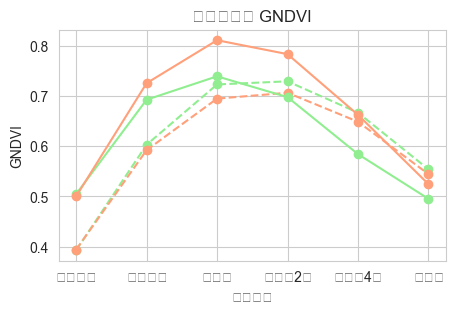

,year,생육단계,시비,초장(cm),LAI,SPAD,NDVI,GNDVI,RVI,CVI,NDRE
19,2024,분얼전기,추비,18.0250,0.51350,35.7675,0.532022,0.500342,4.841085,0.026715,0.229112
18,2024,분얼전기,기비,20.7250,0.57425,34.8525,0.540145,0.504792,5.084960,0.026709,0.234012
7,2023,분얼전기,추비,19.8950,0.14800,37.0625,0.217667,0.394159,1.597134,0.445583,0.099015
6,2023,분얼전기,기비,20.1750,0.09950,40.5125,0.216898,0.392929,1.592585,0.455018,0.099176
20,2024,분얼후기,기비,54.6250,1.63500,43.7525,0.825273,0.692840,13.077876,0.028421,0.401036
21,2024,분얼후기,추비,53.1500,1.11550,40.7675,0.841337,0.725820,14.685837,0.033823,0.451934
8,2023,분얼후기,기비,41.8000,1.01775,46.8475,0.566536,0.603128,4.503692,0.094855,0.260063
9,2023,분얼후기,추비,40.1875,1.10400,44.3725,0.547776,0.592377,4.615248,0.095393,0.247428
1,2023,개화기,추비,61.6000,1.00225,49.4150,0.654768,0.695043,7.842630,0.158890,0.325070
12,2024,개화기,기비,83.0000,2.90450,45.8675,0.811788,0.739498,12.307129,0.045507,0.409072


,year,생육단계,시비,초장(cm),LAI,SPAD,NDVI,GNDVI,RVI,CVI,NDRE
19,2024,분얼전기,추비,18.0250,0.51350,35.7675,0.532022,0.500342,4.841085,0.026715,0.229112
18,2024,분얼전기,기비,20.7250,0.57425,34.8525,0.540145,0.504792,5.084960,0.026709,0.234012
7,2023,분얼전기,추비,19.8950,0.14800,37.0625,0.217667,0.394159,1.597134,0.445583,0.099015
6,2023,분얼전기,기비,20.1750,0.09950,40.5125,0.216898,0.392929,1.592585,0.455018,0.099176
20,2024,분얼후기,기비,54.6250,1.63500,43.7525,0.825273,0.692840,13.077876,0.028421,0.401036
21,2024,분얼후기,추비,53.1500,1.11550,40.7675,0.841337,0.725820,14.685837,0.033823,0.451934
8,2023,분얼후기,기비,41.8000,1.01775,46.8475,0.566536,0.603128,4.503692,0.094855,0.260063
9,2023,분얼후기,추비,40.1875,1.10400,44.3725,0.547776,0.592377,4.615248,0.095393,0.247428
1,2023,개화기,추비,61.6000,1.00225,49.4150,0.654768,0.695043,7.842630,0.158890,0.325070
12,2024,개화기,기비,83.0000,2.90450,45.8675,0.811788,0.739498,12.307129,0.045507,0.409072


,year,생육단계,시비,초장(cm),LAI,SPAD,NDVI,GNDVI,RVI,CVI,NDRE
19,2024,분얼전기,추비,18.0250,0.51350,35.7675,0.532022,0.500342,4.841085,0.026715,0.229112
18,2024,분얼전기,기비,20.7250,0.57425,34.8525,0.540145,0.504792,5.084960,0.026709,0.234012
7,2023,분얼전기,추비,19.8950,0.14800,37.0625,0.217667,0.394159,1.597134,0.445583,0.099015
6,2023,분얼전기,기비,20.1750,0.09950,40.5125,0.216898,0.392929,1.592585,0.455018,0.099176
20,2024,분얼후기,기비,54.6250,1.63500,43.7525,0.825273,0.692840,13.077876,0.028421,0.401036
21,2024,분얼후기,추비,53.1500,1.11550,40.7675,0.841337,0.725820,14.685837,0.033823,0.451934
8,2023,분얼후기,기비,41.8000,1.01775,46.8475,0.566536,0.603128,4.503692,0.094855,0.260063
9,2023,분얼후기,추비,40.1875,1.10400,44.3725,0.547776,0.592377,4.615248,0.095393,0.247428
1,2023,개화기,추비,61.6000,1.00225,49.4150,0.654768,0.695043,7.842630,0.158890,0.325070
12,2024,개화기,기비,83.0000,2.90450,45.8675,0.811788,0.739498,12.307129,0.045507,0.409072


,year,생육단계,시비,초장(cm),LAI,SPAD,NDVI,GNDVI,RVI,CVI,NDRE
19,2024,분얼전기,추비,18.0250,0.51350,35.7675,0.532022,0.500342,4.841085,0.026715,0.229112
18,2024,분얼전기,기비,20.7250,0.57425,34.8525,0.540145,0.504792,5.084960,0.026709,0.234012
7,2023,분얼전기,추비,19.8950,0.14800,37.0625,0.217667,0.394159,1.597134,0.445583,0.099015
6,2023,분얼전기,기비,20.1750,0.09950,40.5125,0.216898,0.392929,1.592585,0.455018,0.099176
20,2024,분얼후기,기비,54.6250,1.63500,43.7525,0.825273,0.692840,13.077876,0.028421,0.401036
21,2024,분얼후기,추비,53.1500,1.11550,40.7675,0.841337,0.725820,14.685837,0.033823,0.451934
8,2023,분얼후기,기비,41.8000,1.01775,46.8475,0.566536,0.603128,4.503692,0.094855,0.260063
9,2023,분얼후기,추비,40.1875,1.10400,44.3725,0.547776,0.592377,4.615248,0.095393,0.247428
1,2023,개화기,추비,61.6000,1.00225,49.4150,0.654768,0.695043,7.842630,0.158890,0.325070
12,2024,개화기,기비,83.0000,2.90450,45.8675,0.811788,0.739498,12.307129,0.045507,0.409072


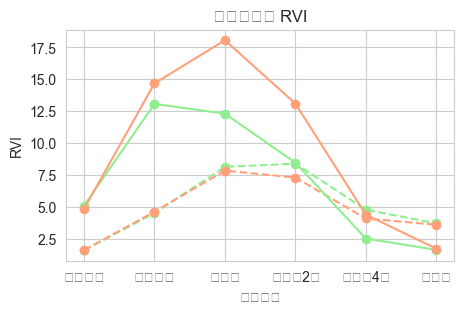

,year,생육단계,시비,초장(cm),LAI,SPAD,NDVI,GNDVI,RVI,CVI,NDRE
19,2024,분얼전기,추비,18.0250,0.51350,35.7675,0.532022,0.500342,4.841085,0.026715,0.229112
18,2024,분얼전기,기비,20.7250,0.57425,34.8525,0.540145,0.504792,5.084960,0.026709,0.234012
7,2023,분얼전기,추비,19.8950,0.14800,37.0625,0.217667,0.394159,1.597134,0.445583,0.099015
6,2023,분얼전기,기비,20.1750,0.09950,40.5125,0.216898,0.392929,1.592585,0.455018,0.099176
20,2024,분얼후기,기비,54.6250,1.63500,43.7525,0.825273,0.692840,13.077876,0.028421,0.401036
21,2024,분얼후기,추비,53.1500,1.11550,40.7675,0.841337,0.725820,14.685837,0.033823,0.451934
8,2023,분얼후기,기비,41.8000,1.01775,46.8475,0.566536,0.603128,4.503692,0.094855,0.260063
9,2023,분얼후기,추비,40.1875,1.10400,44.3725,0.547776,0.592377,4.615248,0.095393,0.247428
1,2023,개화기,추비,61.6000,1.00225,49.4150,0.654768,0.695043,7.842630,0.158890,0.325070
12,2024,개화기,기비,83.0000,2.90450,45.8675,0.811788,0.739498,12.307129,0.045507,0.409072


,year,생육단계,시비,초장(cm),LAI,SPAD,NDVI,GNDVI,RVI,CVI,NDRE
19,2024,분얼전기,추비,18.0250,0.51350,35.7675,0.532022,0.500342,4.841085,0.026715,0.229112
18,2024,분얼전기,기비,20.7250,0.57425,34.8525,0.540145,0.504792,5.084960,0.026709,0.234012
7,2023,분얼전기,추비,19.8950,0.14800,37.0625,0.217667,0.394159,1.597134,0.445583,0.099015
6,2023,분얼전기,기비,20.1750,0.09950,40.5125,0.216898,0.392929,1.592585,0.455018,0.099176
20,2024,분얼후기,기비,54.6250,1.63500,43.7525,0.825273,0.692840,13.077876,0.028421,0.401036
21,2024,분얼후기,추비,53.1500,1.11550,40.7675,0.841337,0.725820,14.685837,0.033823,0.451934
8,2023,분얼후기,기비,41.8000,1.01775,46.8475,0.566536,0.603128,4.503692,0.094855,0.260063
9,2023,분얼후기,추비,40.1875,1.10400,44.3725,0.547776,0.592377,4.615248,0.095393,0.247428
1,2023,개화기,추비,61.6000,1.00225,49.4150,0.654768,0.695043,7.842630,0.158890,0.325070
12,2024,개화기,기비,83.0000,2.90450,45.8675,0.811788,0.739498,12.307129,0.045507,0.409072


,year,생육단계,시비,초장(cm),LAI,SPAD,NDVI,GNDVI,RVI,CVI,NDRE
19,2024,분얼전기,추비,18.0250,0.51350,35.7675,0.532022,0.500342,4.841085,0.026715,0.229112
18,2024,분얼전기,기비,20.7250,0.57425,34.8525,0.540145,0.504792,5.084960,0.026709,0.234012
7,2023,분얼전기,추비,19.8950,0.14800,37.0625,0.217667,0.394159,1.597134,0.445583,0.099015
6,2023,분얼전기,기비,20.1750,0.09950,40.5125,0.216898,0.392929,1.592585,0.455018,0.099176
20,2024,분얼후기,기비,54.6250,1.63500,43.7525,0.825273,0.692840,13.077876,0.028421,0.401036
21,2024,분얼후기,추비,53.1500,1.11550,40.7675,0.841337,0.725820,14.685837,0.033823,0.451934
8,2023,분얼후기,기비,41.8000,1.01775,46.8475,0.566536,0.603128,4.503692,0.094855,0.260063
9,2023,분얼후기,추비,40.1875,1.10400,44.3725,0.547776,0.592377,4.615248,0.095393,0.247428
1,2023,개화기,추비,61.6000,1.00225,49.4150,0.654768,0.695043,7.842630,0.158890,0.325070
12,2024,개화기,기비,83.0000,2.90450,45.8675,0.811788,0.739498,12.307129,0.045507,0.409072


,year,생육단계,시비,초장(cm),LAI,SPAD,NDVI,GNDVI,RVI,CVI,NDRE
19,2024,분얼전기,추비,18.0250,0.51350,35.7675,0.532022,0.500342,4.841085,0.026715,0.229112
18,2024,분얼전기,기비,20.7250,0.57425,34.8525,0.540145,0.504792,5.084960,0.026709,0.234012
7,2023,분얼전기,추비,19.8950,0.14800,37.0625,0.217667,0.394159,1.597134,0.445583,0.099015
6,2023,분얼전기,기비,20.1750,0.09950,40.5125,0.216898,0.392929,1.592585,0.455018,0.099176
20,2024,분얼후기,기비,54.6250,1.63500,43.7525,0.825273,0.692840,13.077876,0.028421,0.401036
21,2024,분얼후기,추비,53.1500,1.11550,40.7675,0.841337,0.725820,14.685837,0.033823,0.451934
8,2023,분얼후기,기비,41.8000,1.01775,46.8475,0.566536,0.603128,4.503692,0.094855,0.260063
9,2023,분얼후기,추비,40.1875,1.10400,44.3725,0.547776,0.592377,4.615248,0.095393,0.247428
1,2023,개화기,추비,61.6000,1.00225,49.4150,0.654768,0.695043,7.842630,0.158890,0.325070
12,2024,개화기,기비,83.0000,2.90450,45.8675,0.811788,0.739498,12.307129,0.045507,0.409072


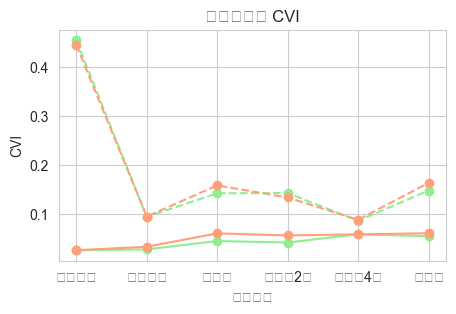

,year,생육단계,시비,초장(cm),LAI,SPAD,NDVI,GNDVI,RVI,CVI,NDRE
19,2024,분얼전기,추비,18.0250,0.51350,35.7675,0.532022,0.500342,4.841085,0.026715,0.229112
18,2024,분얼전기,기비,20.7250,0.57425,34.8525,0.540145,0.504792,5.084960,0.026709,0.234012
7,2023,분얼전기,추비,19.8950,0.14800,37.0625,0.217667,0.394159,1.597134,0.445583,0.099015
6,2023,분얼전기,기비,20.1750,0.09950,40.5125,0.216898,0.392929,1.592585,0.455018,0.099176
20,2024,분얼후기,기비,54.6250,1.63500,43.7525,0.825273,0.692840,13.077876,0.028421,0.401036
21,2024,분얼후기,추비,53.1500,1.11550,40.7675,0.841337,0.725820,14.685837,0.033823,0.451934
8,2023,분얼후기,기비,41.8000,1.01775,46.8475,0.566536,0.603128,4.503692,0.094855,0.260063
9,2023,분얼후기,추비,40.1875,1.10400,44.3725,0.547776,0.592377,4.615248,0.095393,0.247428
1,2023,개화기,추비,61.6000,1.00225,49.4150,0.654768,0.695043,7.842630,0.158890,0.325070
12,2024,개화기,기비,83.0000,2.90450,45.8675,0.811788,0.739498,12.307129,0.045507,0.409072


,year,생육단계,시비,초장(cm),LAI,SPAD,NDVI,GNDVI,RVI,CVI,NDRE
19,2024,분얼전기,추비,18.0250,0.51350,35.7675,0.532022,0.500342,4.841085,0.026715,0.229112
18,2024,분얼전기,기비,20.7250,0.57425,34.8525,0.540145,0.504792,5.084960,0.026709,0.234012
7,2023,분얼전기,추비,19.8950,0.14800,37.0625,0.217667,0.394159,1.597134,0.445583,0.099015
6,2023,분얼전기,기비,20.1750,0.09950,40.5125,0.216898,0.392929,1.592585,0.455018,0.099176
20,2024,분얼후기,기비,54.6250,1.63500,43.7525,0.825273,0.692840,13.077876,0.028421,0.401036
21,2024,분얼후기,추비,53.1500,1.11550,40.7675,0.841337,0.725820,14.685837,0.033823,0.451934
8,2023,분얼후기,기비,41.8000,1.01775,46.8475,0.566536,0.603128,4.503692,0.094855,0.260063
9,2023,분얼후기,추비,40.1875,1.10400,44.3725,0.547776,0.592377,4.615248,0.095393,0.247428
1,2023,개화기,추비,61.6000,1.00225,49.4150,0.654768,0.695043,7.842630,0.158890,0.325070
12,2024,개화기,기비,83.0000,2.90450,45.8675,0.811788,0.739498,12.307129,0.045507,0.409072


,year,생육단계,시비,초장(cm),LAI,SPAD,NDVI,GNDVI,RVI,CVI,NDRE
19,2024,분얼전기,추비,18.0250,0.51350,35.7675,0.532022,0.500342,4.841085,0.026715,0.229112
18,2024,분얼전기,기비,20.7250,0.57425,34.8525,0.540145,0.504792,5.084960,0.026709,0.234012
7,2023,분얼전기,추비,19.8950,0.14800,37.0625,0.217667,0.394159,1.597134,0.445583,0.099015
6,2023,분얼전기,기비,20.1750,0.09950,40.5125,0.216898,0.392929,1.592585,0.455018,0.099176
20,2024,분얼후기,기비,54.6250,1.63500,43.7525,0.825273,0.692840,13.077876,0.028421,0.401036
21,2024,분얼후기,추비,53.1500,1.11550,40.7675,0.841337,0.725820,14.685837,0.033823,0.451934
8,2023,분얼후기,기비,41.8000,1.01775,46.8475,0.566536,0.603128,4.503692,0.094855,0.260063
9,2023,분얼후기,추비,40.1875,1.10400,44.3725,0.547776,0.592377,4.615248,0.095393,0.247428
1,2023,개화기,추비,61.6000,1.00225,49.4150,0.654768,0.695043,7.842630,0.158890,0.325070
12,2024,개화기,기비,83.0000,2.90450,45.8675,0.811788,0.739498,12.307129,0.045507,0.409072


,year,생육단계,시비,초장(cm),LAI,SPAD,NDVI,GNDVI,RVI,CVI,NDRE
19,2024,분얼전기,추비,18.0250,0.51350,35.7675,0.532022,0.500342,4.841085,0.026715,0.229112
18,2024,분얼전기,기비,20.7250,0.57425,34.8525,0.540145,0.504792,5.084960,0.026709,0.234012
7,2023,분얼전기,추비,19.8950,0.14800,37.0625,0.217667,0.394159,1.597134,0.445583,0.099015
6,2023,분얼전기,기비,20.1750,0.09950,40.5125,0.216898,0.392929,1.592585,0.455018,0.099176
20,2024,분얼후기,기비,54.6250,1.63500,43.7525,0.825273,0.692840,13.077876,0.028421,0.401036
21,2024,분얼후기,추비,53.1500,1.11550,40.7675,0.841337,0.725820,14.685837,0.033823,0.451934
8,2023,분얼후기,기비,41.8000,1.01775,46.8475,0.566536,0.603128,4.503692,0.094855,0.260063
9,2023,분얼후기,추비,40.1875,1.10400,44.3725,0.547776,0.592377,4.615248,0.095393,0.247428
1,2023,개화기,추비,61.6000,1.00225,49.4150,0.654768,0.695043,7.842630,0.158890,0.325070
12,2024,개화기,기비,83.0000,2.90450,45.8675,0.811788,0.739498,12.307129,0.045507,0.409072


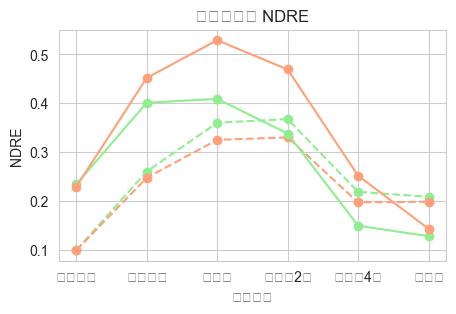

In [76]:
target = '시비'
df_mean = data_mean(target)
# df_mean
drone = ['NDVI', 'GNDVI', 'RVI', 'CVI', 'NDRE']
growth = ['초장(cm)', 'LAI', 'SPAD', ]

for y in growth:
    data_draw(target, df_mean, y, '생육')

for y in drone:

    data_draw(target, df_mean, y, '드론')